In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV,Lasso, LassoLarsCV, LinearRegression,RANSACRegressor
from sklearn.model_selection import cross_val_score,KFold,train_test_split,cross_val_predict, StratifiedKFold
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import *
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from pandas.tools.plotting import scatter_matrix
import statsmodels.formula.api as sm
from scipy.stats import norm
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
import datetime 
from  datetime  import datetime as dt 
from scipy import stats
import operator
from sklearn import cross_validation, grid_search, linear_model, metrics

from sklearn.feature_selection import VarianceThreshold
import re
# import warnings 
# warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data = pd.read_csv('dataset1707.csv', sep=';') #
data = data.loc[data.IS_FIRST==0]
agg686 = pd.read_csv('./doone/fin686.csv', sep=';') #
agg685 = pd.read_csv('./doone/fin685.csv', sep=';') 
agg641 = pd.read_csv('./doone/fin641.csv', sep=';') #
agg560 = pd.read_csv('./doone/fin560.csv', sep=';') #

agg68 = pd.concat([agg686, agg685], ignore_index=1)

data = data.loc[(data['TMP_STP_ALL_AVG']>360)&(data['TMP_STP_ALL_AVG']<700)&(data.TEMP_START_PHASE1!=0)&((data.ADAPTATION_KEY==190409109015)|(data.ADAPTATION_KEY==190309109015))]

data.drop(['TMP_STRT_HED_AVG_M','TMP_STRT_TAIL_AVG_M', 'PROFILE_SDV', u'PROFILE_MIN', u'PROFILE_AVG', u'PROFILE_MAX'], axis=1, inplace=True)
data = data.dropna()

In [12]:
len(data)

9198

In [3]:
data['Vol'] = data['PLT_TCK']*data['PLT_WID']*data['PLT_LEN']*1e-09
data['MEAS_TIME'] = data['MEAS_TIME'].apply(lambda x: dt.strptime(x, "%d.%m.%Y %H:%M:%S"))
data['PREV_MEAS_TIME'] = data['PREV_MEAS_TIME'].apply(lambda x: dt.strptime(x, "%d.%m.%Y %H:%M:%S"))

data['ts_diff'] = (data['TS'] - data['TMP_STP_ALL_AVG']).shift().fillna((data['TS'] - data['TMP_STP_ALL_AVG']).median())  

data['hour'] = 0
data['hour'] = data['MEAS_TIME'].apply(lambda x: x.hour)
data['month']=0
data['month'] = data['MEAS_TIME'].apply(lambda x: x.month)

data['fail'] = 0
data.ix[data.NOT_IN_25_0C==1, 'fail'] = 1
data['meas_date'] =  data['MEAS_TIME'].apply(lambda x: x.date())
data['prev_meas_date'] = data['PREV_MEAS_TIME'].apply(lambda x: x.date())

gg_time = pd.merge(data[[ 'meas_date', 'MEAS_TIME']], data[[ 'meas_date', 'MEAS_TIME','fail']], on='meas_date', how='left')
gg_time['idt'] = 0
gg_time['idt'] = gg_time.MEAS_TIME_x.apply(lambda x: str(x))

# gg_fail =  gg_time.loc[(gg_time.MEAS_TIME_x>gg_time.MEAS_TIME_y)&(gg_time.fail==1)].groupby('idt')['MEAS_TIME_y'].max().reset_index()
# gg_fail.columns = ['MEAS_TIME', 'MEAS_LAST_FAIL']
# gg_fail['MEAS_TIME'] = gg_fail['MEAS_TIME'].apply(lambda x: dt.strptime(x, "%Y-%m-%d %H:%M:%S"))
# data = pd.merge(data, gg_fail, on='MEAS_TIME', how='left')
# data['mins_since_fail'] = (data.MEAS_TIME - data.MEAS_LAST_FAIL).apply(lambda x: x.total_seconds()/60)
# data['mins_since_fail'].fillna(data.mins_since_fail.mean(), inplace=True)


data['diff_mins'] = data['MEAS_TIME'] - data['PREV_MEAS_TIME']
data['diff_mins'] = data['diff_mins'].apply(lambda x: round(x.total_seconds()/60,2))
data['weekday'] = data['MEAS_TIME'].apply(lambda x: x.weekday())
# data['first_cool'] = (data['MEAS_TIME'].apply(lambda x: x.date()) - data['PREV_MEAS_TIME'].apply(lambda x: x.date())).apply(lambda x: x.days)
# data.ix[data.first_cool>0, 'first_cool'] = 1

data['prev_fail'] = data['fail'].shift().fillna(0) 
data['CR_PREV'] = (data['CR_ACT'] - data['CR']).shift().fillna((data['CR_ACT'] - data['CR']).median())  
data['TMP_STP_ALL_PREV'] = data['TMP_STP_ALL_AVG'].shift().fillna(data.TMP_STP_ALL_AVG.median())  

data['ADAPT_TS_MEAN_PREV'] = data['ADAPT_TS_MEAN'].shift().fillna(data.ADAPT_TS_MEAN.median())  

data['tail_head_diff'] = data['TMP_STRT_HEAD_AVG']- data['TMP_STRT_TAIL_AVG']

data['daypart'] = 0
data.ix[(data.hour>8)&(data.hour<=12), 'daypart'] = 1
data.ix[(data.hour>12)&(data.hour<=16), 'daypart'] = 2
data.ix[(data.hour>16)&(data.hour<=20), 'daypart'] = 3
data.ix[(data.hour>20)&(data.hour<=23), 'daypart'] = 4



not25day = data.groupby('meas_date')['NOT_IN_25_0C'].sum().reset_index()
not40day = data.groupby('meas_date')['NOT_IN_40_0C'].sum().reset_index()

not25day.columns = ['meas_date', 'not25day']

not40day.columns = ['meas_date', 'not40day']

data = pd.merge(pd.merge(data,not25day , on='meas_date'), not40day, on='meas_date')


for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>4, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
for col in [ u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>36, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
for col in [ 'EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT']:
    data[col] = data[col].apply(lambda x: x.split('|'))
    data.ix[data[col].apply(lambda x: len(x))>9, col] = data[col].apply(lambda s: map('.'.join, zip(s[::2], s[1::2])))
    
    
for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
    data[col] = data[col].apply(lambda x: [float(i) for i in x])
    

# for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
#        u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
#     data[col+'_sum'] = data[col].apply(lambda x: sum(x))
    
for col in [u'WATER_FLOW_SPRAY_TOP', u'WATER_FLOW_SPRAY_BOTTOM', u'WATER_FLOW_LAM_INNER_TOP', u'WATER_FLOW_LAM_OUTER_TOP',
       u'WATER_FLOW_LAM_INNER_BOT', u'WATER_FLOW_LAM_OUTER_BOT','EDGE_MASKING_POS_DRIVE_SIDE', 'EDGE_MASKING_POS_OP_SIDE', 'BANKS_HEIGHT'] :
    data[col] = data[col].apply(lambda x: np.mean(x))
    
    
    
for col in ['SIDE_SPRAY', 'AIR_BLOWER'] :
    data[col] = data[col].apply(lambda x: str(x.count('0')))
    


agg68.rename(columns={'pltid':'PIECE_ID'}, inplace=1)

df = pd.merge(agg68, data, on='PIECE_ID')    


df.ix[df.month==1,'month']=13
df.ix[df.month==2,'month']=14


# df['40up'] = 0
# df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>480), '40up']=1
# df['40down'] = 0
# df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<480), '40down']=1
# df['25up'] = 0
# df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480), '25up']=1
# df['25down'] = 0
# df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<480), '25down']=1

df['outcome'] = 0
df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>510), 'outcome']=1

df.ix[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<450), 'outcome']=2

df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480), 'outcome']=3

df.ix[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<480),'outcome']=4

todrop = ['GFC.GlobVar.GfcLocRtData.GfcSccWatPrsScc_median', 'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioManRef_ActV_mean',
          'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioManRef_ActV_median', 'GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioManRef_ActV_std',
          'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenBot_SetV_std', 'GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskLenTop_SetV_std', 
          'GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwBot_SetV_std', 'GFC._Hmi2Gfc.Hmi2Gfc.GfcTailMskFlwTop_SetV_std','dist_from plt_mean_std',
          'dist_from plt_sum_std', 'L_ACC','CR','WBF_NO','PODKAT','PODKAT2','PLT_TCK','PLT_WID','PLT_LEN',
          'NOT_ANALYSIS', 'fail']
    
df.drop(todrop, axis=1, inplace=1)
df.fillna(0, axis=1, inplace=1)

df['BHC_out_flow_sum_diff']=df[ 'BHC_out_act_sum_mean']-df['BHC_flow__out_sum_task_mean']
df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff'] =  df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_mean']-df['SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_task_mean']
df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_diff'] =df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_mean'] - df['SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_task_mean']
df['THC_cen_flow_sum_diff'] = df['THC_cen_flow_sum_act_mean'] - df[ 'THC_flow_cen_sum_task_mean']
df['THC_out_degree_sum_diff'] = df['THC_out_degree_sum_act_mean'] - df['THC_out_degree_sum_task_mean']
df['THC_out_flow_sum_diff'] = df['THC_out_flow_sum_act_mean'] - df[ 'THC_out_flow_sum_task_mean']
    
fail40up = df.loc[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG>500)]
fail40down = df.loc[(df.NOT_IN_40_0C==1)&(df.TMP_STP_ALL_AVG<500)]
fail25up = df.loc[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG>480)&(df.NOT_IN_40_0C==0)]
fail25down = df.loc[(df.NOT_IN_25_0C==1)&(df.TMP_STP_ALL_AVG<460)&(df.NOT_IN_40_0C==0)]

good = df.loc[(df.TMP_STP_ALL_AVG<482.5)&(df.TMP_STP_ALL_AVG>477.5)]


ad3 = df.loc[df.ADAPTATION_KEY==190309109015]
ad4 = df.loc[df.ADAPTATION_KEY==190409109015]

suspup = df.loc[(df.TMP_STP_ALL_AVG>500)&(df.NOT_IN_40_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
suspdown = df.loc[(df.TMP_STP_ALL_AVG<480)&(df.NOT_IN_40_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
    
susp25up = df.loc[(df.TMP_STP_ALL_AVG>500)&(df.NOT_IN_25_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
susp25down = df.loc[(df.TMP_STP_ALL_AVG<480)&(df.NOT_IN_25_0C==1)&(df.TMP_STRT_ALL_AVG>743)&(df.TMP_STRT_ALL_AVG<776)&(df.IS_FIRST==0)&(df.prev_fail==0)]
  

numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object' and c!='ADAPTATION_KEY' and c not in ['PPS_PIECE_ID', 'PIECE_ID', 'PIECE_ID_1', 'PIECE_ID_2']]

# df['outcome'] = 0
# df.ix[df.PIECE_ID.isin(fail40up.PIECE_ID), 'outcome'] = 1
# df.ix[df.PIECE_ID.isin(fail25up.PIECE_ID), 'outcome'] = 2
# df.ix[df.PIECE_ID.isin(fail40down.PIECE_ID), 'outcome'] = 3
# df.ix[df.PIECE_ID.isin(fail25down.PIECE_ID), 'outcome'] = 4
# df.ix[df.PIECE_ID.isin(good.PIECE_ID), 'outcome'] = 5

cols = df.columns.difference(['PPS_PIECE_ID','PIECE_ID','PREV_PIECE_ID ','PIECE_ID_2','PIECE_ID_1', 'MEAS_TIME', 'PREV_MEAS_TIME', 'PREV_PIECE_ID', 'NOT_IN_25_0C','NOT_IN_40_0C','IS_FIRST','outcome'])


In [27]:
data.loc[(data.TMP_STP_ALL_AVG<482.5)&(data.TMP_STP_ALL_AVG>477.5)].shape

(1775, 144)

In [23]:
data.loc[(data.NOT_IN_40_0C==1)&(data.TMP_STP_ALL_AVG>500)&(data.NOT_IN_25_0C==1)&(data.TMP_STRT_ALL_AVG>743)&(data.TMP_STRT_ALL_AVG<776)&(data.IS_FIRST==0)&(data.prev_fail==0)].shape

(20, 144)

In [33]:
data.loc[(data.NOT_IN_25_0C==1)&(data.TMP_STP_ALL_AVG>500)&((data.IS_FIRST==1)|(data.BATCH_POSITION==1))].shape

(60, 144)

In [17]:
suspup.shape[0]+suspdown.shape[0]

21

In [26]:
109+27

136

In [30]:
data.loc[(data.TMP_STP_ALL_AVG>500)&(data.NOT_IN_25_0C==1)&(data.TMP_STRT_ALL_AVG>743)&(data.TMP_STRT_ALL_AVG<776)&(data.IS_FIRST==0)&(data.prev_fail==0)].shape


(129, 144)

In [28]:
a = data.loc[data.NOT_IN_25_0C==1].weekday.value_counts()/data.weekday.value_counts()
a.reset_index().sort_values(by='weekday', ascending=0)

,index,weekday
3,3,0.035075
2,2,0.031906
1,1,0.025719
4,4,0.022933
5,5,0.018605
0,0,0.016243
6,6,0.006627


In [29]:
len(set(data.meas_date))

112

In [31]:
data.loc[data.weekday==3].shape

(1397, 144)

In [36]:
data.loc[(data.NOT_IN_25_0C==1)&(data.weekday==3)].meas_date.value_counts()

0017-02-16    13
0016-11-17     7
0016-07-28     6
0017-02-09     6
0016-08-04     5
0016-11-03     3
0016-08-25     3
0016-12-01     2
0016-12-15     2
0016-09-22     1
0017-01-12     1
Name: meas_date, dtype: int64

In [34]:
data.loc[(data.NOT_IN_25_0C==1)&(data.weekday==2)].meas_date.value_counts()

0016-10-26    7
0017-02-08    7
0016-11-09    6
0016-10-12    5
0016-11-02    3
0016-08-24    2
0016-09-14    2
0016-11-30    2
0016-10-19    1
0017-02-15    1
0016-06-01    1
0017-01-11    1
Name: meas_date, dtype: int64

In [81]:
data.groupby('meas_date')['NOT_IN_25_0C'].sum().mean()

1.8392857142857142

In [92]:
data.meas_date[0]

datetime.date(16, 5, 28)

In [97]:
data.loc[(data.meas_date==datetime.date(16, 7, 15))]['NOT_IN_25_0C']

28    1
29    1
Name: NOT_IN_25_0C, dtype: int64

In [98]:
data = data.loc[data.meas_date!=datetime.date(16, 7, 15)]

In [118]:
from sklearn import cross_validation, datasets, linear_model, metrics


In [132]:
fail_std

0.0010653244860459351

In [129]:
fail_mean = data.groupby('meas_date')['NOT_IN_25_0C'].mean().mean()

In [121]:
import math

In [130]:
fail_std = data.groupby('meas_date')['NOT_IN_25_0C'].mean().std(ddof=1)/math.sqrt(len(data))

In [131]:
_tconfint_generic(fail_mean, fail_std, len(data) - 1,0.05, 'two-sided')

(0.036718339457435842, 0.040894879029128015)

In [49]:
data[(data.NOT_IN_25_0C==1)].meas_date.value_counts()

0017-02-16    13
0016-10-18    11
0016-08-29     9
0016-07-29     9
0016-11-17     7
0016-09-13     7
0017-02-17     7
0017-02-08     7
0016-10-26     7
0017-02-09     6
0016-07-28     6
0016-11-09     6
0016-10-12     5
0016-08-04     5
0016-08-05     4
0016-08-26     4
0016-08-20     4
0016-10-11     3
0017-02-18     3
0016-11-02     3
0016-11-22     3
0016-12-04     3
0016-12-03     3
0016-08-25     3
0016-10-17     3
0016-08-23     3
0016-11-03     3
0016-12-12     3
0017-01-16     2
0016-12-15     2
              ..
0017-02-15     1
0016-10-25     1
0017-01-11     1
0016-11-07     1
0016-10-14     1
0016-10-23     1
0016-10-10     1
0016-10-19     1
0016-09-22     1
0016-12-23     1
0016-06-01     1
0016-10-24     1
0016-05-28     1
0017-01-12     1
0016-12-05     1
0016-11-20     1
0017-01-17     1
0016-08-21     1
0017-01-10     1
0016-09-09     1
0016-11-25     1
0016-08-28     1
0016-10-15     1
0016-09-11     1
0016-12-13     1
0016-10-22     1
0016-11-08     1
0016-10-16    

In [160]:
data.loc[(data.NOT_IN_25_0C==1)&(data.hour==13)].meas_date.value_counts()

0016-08-20    3
0016-10-12    3
0017-02-09    2
0016-10-21    2
0016-08-04    1
0016-10-18    1
0016-11-02    1
0016-11-09    1
0016-10-17    1
0016-12-23    1
0016-08-06    1
Name: meas_date, dtype: int64

In [ ]:
k.loc[k.isnull()==0].reset_index().sort_values(by='meas_date', ascending=0)

In [133]:
k=data.loc[(data.NOT_IN_25_0C==1)&(data.hour==13)].meas_date.value_counts()
k.loc[k.isnull()==0].reset_index().sort_values(by='meas_date', ascending=0)

,index,meas_date
0,0016-08-20,3
1,0016-10-12,3
2,0017-02-09,2
3,0016-10-21,2
4,0016-08-04,1
5,0016-10-18,1
6,0016-11-02,1
7,0016-11-09,1
8,0016-10-17,1
9,0016-12-23,1


In [47]:
k=data.loc[(data.NOT_IN_25_0C==1)&(data.hour==13)].meas_date.value_counts()/data.meas_date.value_counts()
k.loc[k.isnull()==0].reset_index().sort_values(by='meas_date', ascending=0)

,index,meas_date
3,0016-10-12,0.037975
6,0016-10-21,0.035714
2,0016-08-20,0.027273
9,0016-12-23,0.022222
10,0017-02-09,0.022222
7,0016-11-02,0.016667
5,0016-10-18,0.011765
4,0016-10-17,0.011494
8,0016-11-09,0.010989
0,0016-08-04,0.010204


In [159]:
b = data.loc[data.NOT_IN_25_0C==1].hour.value_counts()/data.hour.value_counts()
b = b.reset_index().sort_values(by='hour', ascending=0)
b.hour = b.hour*100
b

,index,hour
13,13,4.473684
10,10,3.865979
18,18,3.626943
4,4,3.466667
1,1,3.194103
14,14,2.985075
2,2,2.941176
22,22,2.941176
16,16,2.770083
7,7,2.571429


In [64]:
d = data.loc[data.NOT_IN_25_0C==1].daypart.value_counts()/data.daypart.value_counts()
d.reset_index().sort_values(by='daypart', ascending=0)

,index,daypart
2,2,0.028327
1,1,0.023762
3,3,0.023361
0,0,0.020546
4,4,0.017256


In [156]:
data.loc[(data.NOT_IN_25_0C==1)&(data.month==6)].meas_date

9    0016-06-01
Name: meas_date, dtype: object

In [153]:
d = data.loc[(data.NOT_IN_25_0C==1)&(data.month!=5)].month.value_counts()/data.month.value_counts()
d = d.reset_index().sort_values(by='month', ascending=0)
d.month = d.month*100
d

,index,month
1,2,5.172414
3,6,4.347826
4,7,3.925234
7,10,2.612671
5,8,2.291422
9,12,1.848592
8,11,1.848539
6,9,1.794616
0,1,1.304348
2,5,NaN


In [145]:
data.loc[data.month==5]['NOT_IN_25_0C']

0    1
1    1
2    0
3    0
4    0
5    0
6    0
Name: NOT_IN_25_0C, dtype: int64

In [141]:
max(data.meas_date)

datetime.date(17, 2, 18)

In [142]:
data.month.value_counts()

8     1702
11    1677
10    1531
12    1136
9     1003
1      920
2      754
7      535
6       23
5        7
Name: month, dtype: int64

In [4]:
df.weekday.value_counts()/df.loc[df.NOT_IN_25_0C==1].weekday.value_counts()

0    950
3    897
4    890
2    793
6    789
1    619
5    489
Name: weekday, dtype: int64

In [5]:
df.loc[df.NOT_IN_25_0C==1].weekday.value_counts()

3    34
2    29
1    15
4    13
0    13
5     9
6     6
Name: weekday, dtype: int64

In [6]:
data[['TMP_STP_ALL_AVG', 'ADAPT_TS_MEAN']].corr()

,TMP_STP_ALL_AVG,ADAPT_TS_MEAN
TMP_STP_ALL_AVG,1.000,-0.185
ADAPT_TS_MEAN,-0.185,1.000


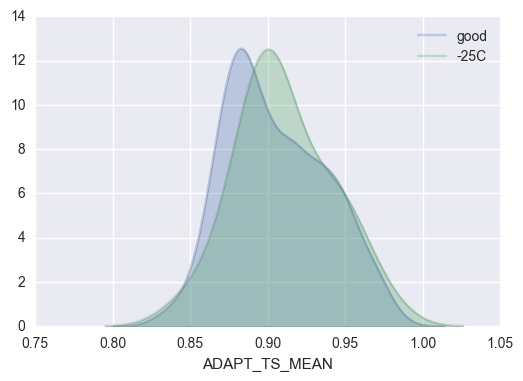

In [20]:
fig, ax = plt.subplots()
sns.distplot(good['ADAPT_TS_MEAN'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='good')
sns.distplot(susp25down['ADAPT_TS_MEAN'], hist=False, kde_kws={"shade": True, 'alpha':0.3}, ax=ax, label='-25C')

In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',264)

h = pd.concat([fail40up[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
h.columns = ['index', 'fail40up_mean','good_mean']

h['diff']=0
h['diff'] = abs((h.fail40up_mean - h.good_mean)/(h[['fail40up_mean','good_mean']].mean(axis=1)))
h.sort_values(by='diff', ascending=0,inplace=1)
# h.to_csv('./tables/fail40up.csv',index=0, sep=';' )
h

,index,fail40up_mean,good_mean,diff
124,SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_diff,-98.917,16.072,2.776
117,SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff,-249.141,20.341,2.356
94,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_std,0.000,0.012,2.000
97,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.000,0.002,2.000
66,DIF_TMP_ALL,53.327,0.080,1.994
51,DEF_CR,-2.601,-0.064,1.905
243,prev_fail,0.273,0.010,1.861
57,DIF_LAM_BDY_TAIL,-0.168,-0.008,1.817
54,DIF_BDY_TAIL,-0.228,-0.011,1.817
59,DIF_SPRAY_BDY_TAIL,-0.060,-0.003,1.816


In [5]:
todrop2 = [ 'L_ACC','CR','WBF_NO','PODKAT','PODKAT2','PLT_TCK','PLT_WID','PLT_LEN','prev_meas_date',
          'NOT_ANALYSIS', 'fail','PPS_PIECE_ID','PIECE_ID','PIECE_ID_2','PIECE_ID_1','PREV_PIECE_ID', 'meas_date', 'MEAS_TIME', 'PREV_MEAS_TIME']
    
data.drop(todrop2, axis=1, inplace=1)

In [6]:
c = ['TMP_STRT_TOT_AVG_M',
 'TMP_STRT_BDY_AVG_M',
 'TMP_STRT_TOT_MAX_M',
 'TMP_STA_TOT_MIN_M',

 'TMP_STRT_HEAD_AVG',
 'TMP_STRT_HEAD_MIN',
 'TMP_STRT_HEAD_MAX',
 'TMP_STRT_HEAD_DEV',
 'TMP_STRT_BDY_AVG',
 'TMP_STRT_BDY_MIN',
 'TMP_STRT_BDY_MAX',
 'TMP_STRT_BDY_DEV',
 'TMP_STRT_TAIL_AVG',
 'TMP_STRT_TAIL_MIN',
 'TMP_STRT_TAIL_MAX',
 'TMP_STRT_TAIL_DEV',
 'TMP_STRT_ALL_AVG',
 'TMP_STRT_ALL_MIN',
 'TMP_STRT_ALL_MAX',
 'TMP_STRT_ALL_DEV',


 'FURT10',
 'FURT40',


 'UNIFORMITY',

 'TEMP_OVERHEATING',
 'TEMP_START_PHASE1',
 'TEMP_START_PHASE2',
 'TEMP_END_PHASE2',
 'DIF_TEMP_START',
 'DIF_TFM',
 'DIF_STRT_TOT_AVG',
 'DIF_STRT_HED_AVG',
 'DIF_STRT_TAIL_AVG',
 'DIF_STRT_TOT',
 'DIF_BDY_HEAD',
 'DIF_BDY_TAIL',

 'Vol']

In [55]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

a = pd.concat([suspup[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
a.columns = ['index', 'susp40up_mean','good_mean']

a['diff']=0
a['diff'] = abs((a.susp40up_mean - a.good_mean)/(a[['susp40up_mean','good_mean']].mean(axis=1)))
a.sort_values(by='diff', ascending=0,inplace=1)
a.to_csv('./tables/suspup.csv',index=0, sep=';' )
a

,index,susp40up_mean,good_mean,diff
123,SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_diff,-159.325,16.072,2.449
58,DIF_SPRAY_BDY_TAIL,0.029,-0.003,2.433
53,DIF_BDY_TAIL,0.112,-0.011,2.432
56,DIF_LAM_BDY_TAIL,0.083,-0.008,2.431
116,SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff,-400.606,20.341,2.214
244,ts_diff,0.016,-0.739,2.087
242,prev_fail,0.000,0.010,2.000
96,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.000,0.002,2.000
93,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_std,0.000,0.012,2.000
65,DIF_TMP_ALL,49.131,0.080,1.994


In [56]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

b= pd.concat([suspdown[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

b.columns = ['index', 'susp40down_mean','good_mean']

b['diff']=0
b['diff'] = abs((b.susp40down_mean - b.good_mean)/(b[['susp40down_mean','good_mean']].mean(axis=1)))
b.sort_values(by='diff', ascending=0,inplace=1)

b.to_csv('./tables/suspdown.csv',index=0, sep=';' )
b


,index,susp40down_mean,good_mean,diff
45,CR_PREV,0.386,-0.069,2.867
244,ts_diff,5.369,-0.739,2.639
58,DIF_SPRAY_BDY_TAIL,0.030,-0.003,2.430
53,DIF_BDY_TAIL,0.113,-0.011,2.428
56,DIF_LAM_BDY_TAIL,0.083,-0.008,2.428
50,DEF_CR,1.422,-0.064,2.187
65,DIF_TMP_ALL,-54.165,0.080,2.006
93,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_std,0.000,0.012,2.000
96,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.000,0.002,2.000
242,prev_fail,0.000,0.010,2.000


In [57]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

j= pd.concat([susp25up[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

j.columns = ['index', 'susp25up_mean','good_mean']
j['diff']=0
j['diff'] = abs((j.susp25up_mean - j.good_mean)/(j[['susp25up_mean','good_mean']].mean(axis=1)))
j.sort_values(by='diff', ascending=0,inplace=1)

j.to_csv('./tables/susp25up.csv',index=0, sep=';' )
j


,index,susp25up_mean,good_mean,diff
123,SCC._SccRtData.SccRtData.SpecFlw_TOP_SUM_diff,-11.302,16.072,11.479
58,DIF_SPRAY_BDY_TAIL,0.007,-0.003,4.987
53,DIF_BDY_TAIL,0.026,-0.011,4.971
56,DIF_LAM_BDY_TAIL,0.019,-0.008,4.965
116,SCC._SccRtData.SccRtData.SpecFlw_Bot_SUM_diff,-48.240,20.341,4.916
242,prev_fail,0.000,0.010,2.000
65,DIF_TMP_ALL,32.542,0.080,1.990
50,DEF_CR,-1.628,-0.064,1.850
96,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.016,0.002,1.518
111,PLT_ACCELERATION,0.041,0.013,1.032


In [58]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

g= pd.concat([susp25down[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()

g.columns = ['index', 'susp25down_mean','good_mean']
g['diff']=0
g['diff'] = abs((g.susp25down_mean - g.good_mean)/(g[['susp25down_mean','good_mean']].mean(axis=1)))
g.sort_values(by='diff', ascending=0,inplace=1)
g.to_csv('./tables/susp25down.csv',index=0, sep=';' )
g


,index,susp25down_mean,good_mean,diff
64,DIF_TFM,0.959,-2.214,5.057
50,DEF_CR,0.986,-0.064,2.276
58,DIF_SPRAY_BDY_TAIL,0.046,-0.003,2.268
53,DIF_BDY_TAIL,0.175,-0.011,2.267
56,DIF_LAM_BDY_TAIL,0.129,-0.008,2.267
65,DIF_TMP_ALL,-37.151,0.080,2.009
96,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.000,0.002,2.000
242,prev_fail,0.000,0.010,2.000
93,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_std,0.000,0.012,2.000
81,GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMo...,0.000,0.000,1.707


In [59]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',274)

b= pd.concat([suspdown[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
b.columns = ['index', 'susp40down_mean','good_mean']
b['diff']=0
b['diff'] = abs((b.susp40down_mean -b.good_mean)/(b[['susp40down_mean','good_mean']].mean(axis=1)))
b.sort_values(by='diff', ascending=0,inplace=1)

b.to_csv('./tables/suspdown.csv',index=0, sep=';' )
b


,index,susp40down_mean,good_mean,diff
45,CR_PREV,0.386,-0.069,2.867
244,ts_diff,5.369,-0.739,2.639
58,DIF_SPRAY_BDY_TAIL,0.030,-0.003,2.430
53,DIF_BDY_TAIL,0.113,-0.011,2.428
56,DIF_LAM_BDY_TAIL,0.083,-0.008,2.428
50,DEF_CR,1.422,-0.064,2.187
65,DIF_TMP_ALL,-54.165,0.080,2.006
93,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_std,0.000,0.012,2.000
96,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.000,0.002,2.000
242,prev_fail,0.000,0.010,2.000


In [60]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',255)

c = pd.concat([fail25up[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
c.columns = ['index', 'fail25up_mean','good_mean']
c['diff']=0
c['diff'] = abs((c.fail25up_mean - c.good_mean)/(c[['fail25up_mean','good_mean']].mean(axis=1)))
c.sort_values(by='diff', ascending=0,inplace=1)

c.to_csv('./tables/fail25up.csv',index=0, sep=';' )
c

,index,fail25up_mean,good_mean,diff
56,DIF_LAM_BDY_TAIL,0.004,-0.008,5.717
53,DIF_BDY_TAIL,0.005,-0.011,5.709
58,DIF_SPRAY_BDY_TAIL,0.001,-0.003,5.686
65,DIF_TMP_ALL,28.997,0.080,1.989
50,DEF_CR,-1.367,-0.064,1.822
242,prev_fail,0.121,0.010,1.700
96,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.018,0.002,1.549
244,ts_diff,-5.434,-0.739,1.521
45,CR_PREV,-0.297,-0.069,1.248
111,PLT_ACCELERATION,0.040,0.013,1.009


In [61]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',255)

d = pd.concat([fail40down[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
d.columns = ['index', 'fail40down_mean','good_mean']
d['diff']=0
d['diff'] = abs((d.fail40down_mean - d.good_mean)/(d[['fail40down_mean','good_mean']].mean(axis=1)))
d.sort_values(by='diff', ascending=0,inplace=1)


d.to_csv('./tables/fail40down.csv',index=0, sep=';' )
d

,index,fail40down_mean,good_mean,diff
45,CR_PREV,0.265,-0.069,3.399
58,DIF_SPRAY_BDY_TAIL,0.014,-0.003,3.067
53,DIF_BDY_TAIL,0.052,-0.011,3.063
56,DIF_LAM_BDY_TAIL,0.038,-0.008,3.061
244,ts_diff,7.093,-0.739,2.465
50,DEF_CR,1.362,-0.064,2.196
65,DIF_TMP_ALL,-50.615,0.080,2.006
96,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwTop_SetV_std,0.000,0.002,2.000
93,GFC._Hmi2Gfc.Hmi2Gfc.GfcHeadMskFlwBot_SetV_std,0.000,0.012,2.000
81,GFC._Gfc2Hmi.Gfc2Hmi.GfcHmiBtmTopFlwRatioSetMo...,0.001,0.000,1.872


In [62]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows',255)

f = pd.concat([fail25down[cols].describe().loc['mean'],good[cols].describe().loc['mean'] ], axis=1).reset_index()
f.columns = ['index', 'fail25down_mean','good_mean']
f['diff']=0
f['diff'] = abs((f.fail25down_mean - f.good_mean)/(f[['fail25down_mean','good_mean']].mean(axis=1)))
f.sort_values(by='diff', ascending=0,inplace=1)


f.to_csv('./tables/fail25down.csv',index=0, sep=';' )
f

,index,fail25down_mean,good_mean,diff
64,DIF_TFM,1.285,-2.214,7.531
111,PLT_ACCELERATION,-0.002,0.013,2.687
50,DEF_CR,0.832,-0.064,2.331
58,DIF_SPRAY_BDY_TAIL,0.047,-0.003,2.259
53,DIF_BDY_TAIL,0.180,-0.011,2.259
56,DIF_LAM_BDY_TAIL,0.133,-0.008,2.258
55,DIF_LAM_BDY_HEAD,-0.008,0.160,2.223
51,DIF_BDY_HEAD,-0.011,0.216,2.222
57,DIF_SPRAY_BDY_HEAD,-0.003,0.057,2.222
65,DIF_TMP_ALL,-29.962,0.080,2.011
